In [1]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [3]:
IM_SHAPE=(224,224)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [4]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#from keras.applications import DenseNet121

from keras.applications import nasnet 
vgg =  nasnet.NASNetMobile(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-01-29 23:15:56.937407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 23:15:57.029830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 23:15:57.030668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 23:15:57.032067: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

20004864/19993432 [==============================] - 2s 0us/step


In [6]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fee6da92ad0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7fee6c0b2d50>,stem_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fee6c7bf650>,stem_bn1,False
3,<keras.layers.core.Activation object at 0x7fee6c96a6d0>,activation,False
4,<keras.layers.convolutional.Conv2D object at 0x7fee6c7b34d0>,reduction_conv_1_stem_1,False
...,...,...,...
765,<keras.layers.merge.Add object at 0x7fee40795150>,normal_add_4_12,False
766,<keras.layers.merge.Add object at 0x7fee407c1ed0>,normal_add_5_12,False
767,<keras.layers.merge.Concatenate object at 0x7fee407c10d0>,normal_concat_12,False
768,<keras.layers.core.Activation object at 0x7fee6d8545d0>,activation_187,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


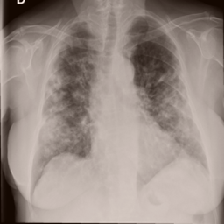

In [8]:
array_to_img(train_generator_NEW[0][0][0])

2023-01-29 23:16:07.156141: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 23:16:12.022049: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 7, 7, 1056)


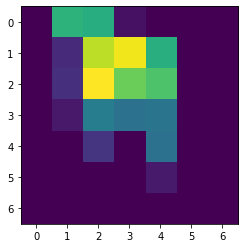

In [9]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [10]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(1024, activation='relu')) 
model_TF.add(Dropout(0.25)) 
model_TF.add(Dense(512, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 51744)             4269716   
_________________________________________________________________
dense (Dense)                (None, 1024)              52986880  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [11]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [12]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 197s 410ms/step - loss: 0.3935 - accuracy: 0.8355 - f1_m: 0.7024 - precision_m: 0.8724 - recall_m: 0.6038 - val_loss: 0.1890 - val_accuracy: 0.9216 - val_f1_m: 0.9159 - val_precision_m: 0.9275 - val_recall_m: 0.9052
Epoch 2/15
452/452 [==============================] - 74s 165ms/step - loss: 0.2373 - accuracy: 0.9009 - f1_m: 0.8636 - precision_m: 0.9080 - recall_m: 0.8266 - val_loss: 0.1729 - val_accuracy: 0.9285 - val_f1_m: 0.9234 - val_precision_m: 0.9304 - val_recall_m: 0.9170
Epoch 3/15
452/452 [==============================] - 76s 168ms/step - loss: 0.1987 - accuracy: 0.9193 - f1_m: 0.8724 - precision_m: 0.9472 - recall_m: 0.8118 - val_loss: 0.1468 - val_accuracy: 0.9385 - val_f1_m: 0.9162 - val_precision_m: 0.9777 - val_recall_m: 0.8634
Epoch 4/15
452/452 [==============================] - 74s 164ms/step - loss: 0.1741 - accuracy: 0.9300 - f1_m: 0.8855 - precision_m: 0.9614 - recall_m: 0.8234 - val_loss: 0.1241 - val_accuracy: 0.9524 - 

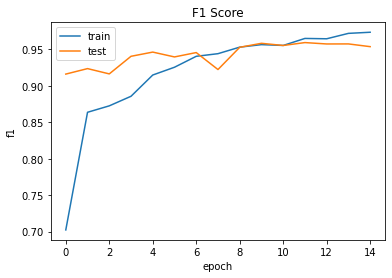

In [13]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 20s 315ms/step - loss: 0.1541 - accuracy: 0.9480 - f1_m: 0.9449 - precision_m: 0.9543 - recall_m: 0.9360


In [15]:
test_loss

[0.15413913130760193,
 0.9480000138282776,
 0.9448639750480652,
 0.9543171525001526,
 0.9360119104385376]

In [16]:
from keras.applications import nasnet 
dense =  nasnet.NASNetMobile(include_top=False, 
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True


In [17]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 51744)             4269716   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              52986880  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [19]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 215s 430ms/step - loss: 0.2425 - accuracy: 0.9008 - f1_m: 0.8366 - precision_m: 0.9217 - recall_m: 0.7728 - val_loss: 0.3946 - val_accuracy: 0.8131 - val_f1_m: 0.7656 - val_precision_m: 0.8537 - val_recall_m: 0.6966
Epoch 2/15
452/452 [==============================] - 189s 417ms/step - loss: 0.0863 - accuracy: 0.9694 - f1_m: 0.9512 - precision_m: 0.9811 - recall_m: 0.9241 - val_loss: 0.2892 - val_accuracy: 0.8836 - val_f1_m: 0.8336 - val_precision_m: 0.9264 - val_recall_m: 0.7605
Epoch 3/15
452/452 [==============================] - 190s 420ms/step - loss: 0.0435 - accuracy: 0.9856 - f1_m: 0.9757 - precision_m: 0.9909 - recall_m: 0.9615 - val_loss: 0.2368 - val_accuracy: 0.9135 - val_f1_m: 0.8931 - val_precision_m: 0.9442 - val_recall_m: 0.8487
Epoch 4/15
452/452 [==============================] - 189s 419ms/step - loss: 0.0254 - accuracy: 0.9914 - f1_m: 0.9863 - precision_m: 0.9947 - recall_m: 0.9784 - val_loss: 0.1952 - val_accur

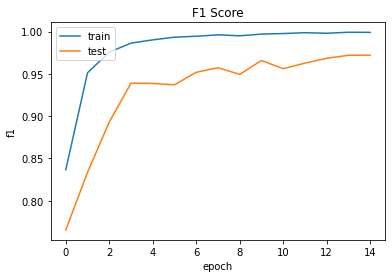

In [20]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 9s 136ms/step - loss: 0.1286 - accuracy: 0.9780 - f1_m: 0.9776 - precision_m: 0.9781 - recall_m: 0.9772


In [22]:
test_loss

[0.12860043346881866,
 0.9779999852180481,
 0.977647066116333,
 0.978126585483551,
 0.9771825671195984]